Reading and pre-processing of time-series data for 4 stations in Delhi

Datset has 13 Columns out of which 12 are pollutants like PM2.5, PM10, NO, etc.
Please find the Data from data_new folder.


In [1]:
from math import sqrt
import numpy as np
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
from keras.layers import Dropout
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import seaborn as sn
import copy


# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

# Anand Vihar
dfav = read_csv('/content/anand_vihar_jan19_dec20_8h.csv')
dfav.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']

# Bawana
dfbw= read_csv('/content/Bawana_jan19-dec20_8h.csv')
dfbw.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']

# Vivek Vihar
dfvv = read_csv('/content/vivek_vihar_jan19_dec20_8h.csv')
dfvv.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']


dfwz = read_csv('/content/Wazirpur_8h_jan19-dec20.csv')
dfwz.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']


# DTU
dfdt = read_csv('/content/DTU_8h_jan19-dec20.csv')
dfdt.columns = ['From Date','PM10','NO','NO2','WS','CO','Benzene','NOx','Ozone','SO2','NH3','Toluene','PM2.5']



# Edit it accordingly for 4 different stations: Currently set-up for Anand Vihar
df= dfav

print("Shape of df:",df.shape)


print(df.head(5))


df = df.replace(to_replace='None', value=np.nan)
df = df.dropna(axis = 0, how = 'all')
df['PM10'].fillna(df['PM10'].median(), inplace=True)
df['NO'].fillna(df['NO'].median(), inplace=True)
df['NO2'].fillna(df['NO2'].median(), inplace=True)
df['WS'].fillna(df['WS'].median(), inplace=True)
df['CO'].fillna(df['CO'].median(), inplace=True)
df['Benzene'].fillna(df['Benzene'].median(), inplace=True)
df['NOx'].fillna(df['NOx'].median(), inplace=True)
df['Ozone'].fillna(df['Ozone'].median(), inplace=True)
df['SO2'].fillna(df['SO2'].median(), inplace=True)
df['NH3'].fillna(df['NH3'].median(), inplace=True)
df['Toluene'].fillna(df['Toluene'].median(), inplace=True)
df['PM2.5'].fillna(df['PM2.5'].median(), inplace=True)

print(" \nCount total NaN at each column in a DataFrame : \n\n", df.isnull().sum())


Shape of df: (2128, 13)
          From Date    PM10      NO     NO2    WS    CO Benzene     NOx  \
0  01-01-2019 00:00  752.78  179.68  111.66   0.3  3.52   20.45   251.7   
1  01-01-2019 08:00  408.19  135.13  148.64  0.53  4.57    9.75  189.21   
2  01-01-2019 16:00  475.85  123.27  177.02  0.31  5.66   17.79  176.38   
3  02-01-2019 00:00  771.27  357.61  106.05   0.3  5.96    20.9  350.56   
4  02-01-2019 08:00  495.06    75.6  125.28  1.13  1.56   10.11  128.26   

   Ozone    SO2     NH3 Toluene   PM2.5  
0  22.86  10.79   93.35   58.33  492.03  
1  22.68  13.86   104.4   31.63  266.16  
2  26.04  21.74   89.24   89.25   382.5  
3  61.84   5.99  109.64   99.34  545.28  
4  34.37  19.54  108.53   57.46  344.22  
 
Count total NaN at each column in a DataFrame : 

 From Date    0
PM10         0
NO           0
NO2          0
WS           0
CO           0
Benzene      0
NOx          0
Ozone        0
SO2          0
NH3          0
Toluene      0
PM2.5        0
dtype: int64


In [2]:
df.head()

,From Date,PM10,NO,NO2,WS,CO,Benzene,NOx,Ozone,SO2,NH3,Toluene,PM2.5
0,01-01-2019 00:00,752.78,179.68,111.66,0.3,3.52,20.45,251.7,22.86,10.79,93.35,58.33,492.03
1,01-01-2019 08:00,408.19,135.13,148.64,0.53,4.57,9.75,189.21,22.68,13.86,104.4,31.63,266.16
2,01-01-2019 16:00,475.85,123.27,177.02,0.31,5.66,17.79,176.38,26.04,21.74,89.24,89.25,382.5
3,02-01-2019 00:00,771.27,357.61,106.05,0.3,5.96,20.9,350.56,61.84,5.99,109.64,99.34,545.28
4,02-01-2019 08:00,495.06,75.6,125.28,1.13,1.56,10.11,128.26,34.37,19.54,108.53,57.46,344.22


In [3]:
features = df.loc[:, df.columns != 'From Date']
features = features.astype(float)
features.head()

,PM10,NO,NO2,WS,CO,Benzene,NOx,Ozone,SO2,NH3,Toluene,PM2.5
0,752.78,179.68,111.66,0.30,3.52,20.45,251.70,22.86,10.79,93.35,58.33,492.03
1,408.19,135.13,148.64,0.53,4.57,9.75,189.21,22.68,13.86,104.40,31.63,266.16
2,475.85,123.27,177.02,0.31,5.66,17.79,176.38,26.04,21.74,89.24,89.25,382.50
3,771.27,357.61,106.05,0.30,5.96,20.90,350.56,61.84,5.99,109.64,99.34,545.28
4,495.06,75.60,125.28,1.13,1.56,10.11,128.26,34.37,19.54,108.53,57.46,344.22


The following code computes statistical measures (minimum, maximum, mean, and standard deviation) for various air quality features. These features include PM10, NO, NO2, WS (wind speed), CO, Benzene, NOx, Ozone, SO2, NH3, Toluene, and PM2.5.

In [4]:
# Table for range, mean and std for different features
feat = features['PM10'].values
print("PM10 :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['NO'].values
print("NO :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['NO2'].values
print("NO2 :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['WS'].values
print("WS :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['CO'].values
print("CO :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['Benzene'].values
print("Benzene :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['NOx'].values
print("NOx :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['Ozone'].values
print("Ozone :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['SO2'].values
print("SO2 :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['NH3'].values
print("NH3 :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['Toluene'].values
print("Toluene :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))
feat = features['PM2.5'].values
print("PM2.5 :", "Min = ",min(feat), ", Max = ", max(feat) , ", Mean = ", np.mean(feat), ", Std = ",np.std(feat))

PM10 : Min =  14.19 , Max =  939.3 , Mean =  238.9531672932331 , Std =  158.7151124412036
NO : Min =  0.3 , Max =  490.9 , Mean =  80.59628289473683 , Std =  78.37593403856881
NO2 : Min =  0.43 , Max =  360.51 , Mean =  74.19296052631579 , Std =  41.03640331881324
WS : Min =  0.3 , Max =  4.43 , Mean =  0.8629652255639098 , Std =  0.6816515731748818
CO : Min =  0.01 , Max =  7.21 , Mean =  2.135610902255639 , Std =  1.1021416706289533
Benzene : Min =  0.0 , Max =  30.82 , Mean =  3.860859962406015 , Std =  3.40661718730482
NOx : Min =  0.13 , Max =  472.48 , Mean =  107.18660714285713 , Std =  80.07864466359113
Ozone : Min =  1.42 , Max =  180.38 , Mean =  36.150296052631575 , Std =  26.33671023268468
SO2 : Min =  0.5 , Max =  94.36 , Mean =  13.567551691729323 , Std =  9.504119005743535
NH3 : Min =  0.1 , Max =  136.3 , Mean =  44.778796992481205 , Std =  23.78438681104865
Toluene : Min =  0.0 , Max =  450.98 , Mean =  32.05791353383458 , Std =  40.86692184975187
PM2.5 : Min =  6.93 ,

Correlation Matrix and Heatmap for features

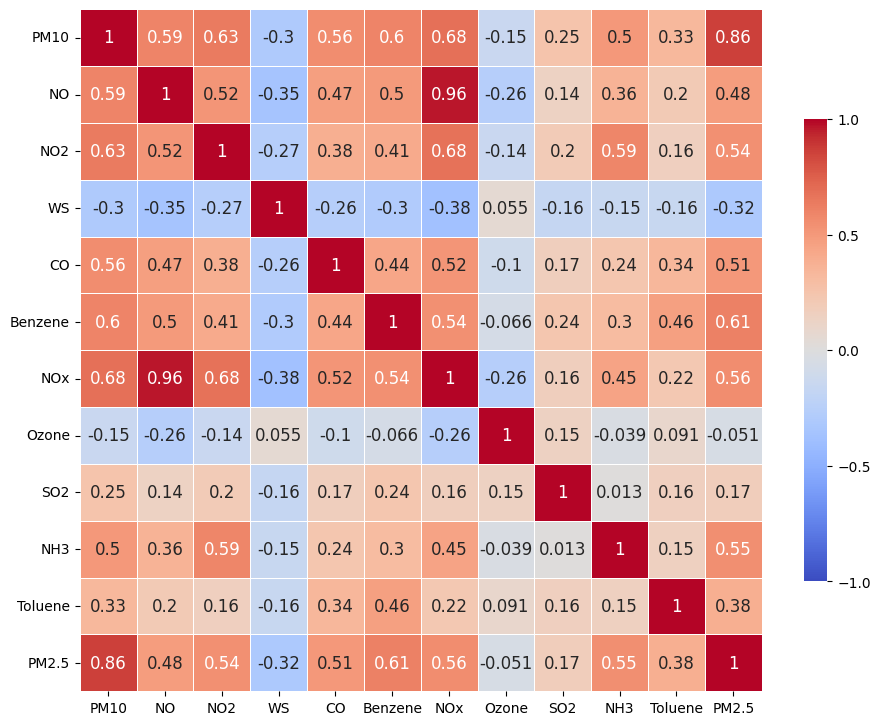

In [5]:

corr_matrix = features.corr()
f, ax = plt.subplots(figsize=(11, 15))
heatmap = sn.heatmap(corr_matrix,
                      #mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sn.set_style({'xtick.bottom': True}, {'ytick.left': True})

Preparation of dataframe for analysis

In [6]:
df['Date'] = pd.to_datetime(df['From Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['hour'] = df['Date'].dt.hour
df['minute'] = df['Date'].dt.minute


In [ ]:
df.head()

,From Date,PM10,NO,NO2,WS,CO,Benzene,NOx,Ozone,SO2,NH3,Toluene,PM2.5,Date,year,month,day,hour,minute
0,01-01-2019 00:00,752.78,179.68,111.66,0.3,3.52,20.45,251.7,22.86,10.79,93.35,58.33,492.03,2019-01-01 00:00:00,2019,1,1,0,0
1,01-01-2019 08:00,408.19,135.13,148.64,0.53,4.57,9.75,189.21,22.68,13.86,104.4,31.63,266.16,2019-01-01 08:00:00,2019,1,1,8,0
2,01-01-2019 16:00,475.85,123.27,177.02,0.31,5.66,17.79,176.38,26.04,21.74,89.24,89.25,382.5,2019-01-01 16:00:00,2019,1,1,16,0
3,02-01-2019 00:00,771.27,357.61,106.05,0.3,5.96,20.9,350.56,61.84,5.99,109.64,99.34,545.28,2019-02-01 00:00:00,2019,2,1,0,0
4,02-01-2019 08:00,495.06,75.6,125.28,1.13,1.56,10.11,128.26,34.37,19.54,108.53,57.46,344.22,2019-02-01 08:00:00,2019,2,1,8,0


Splitting into train/test for different LSTM models.

In [7]:
df_train = df[(df["year"] <2020) | (df['month']<=5)]

df_test=df[(df["year"] >2019) & (df['month']<=12) & (df['month']>5)]
df.to_csv('pollution.csv')
df_train.to_csv('train_pollution.csv')
df_test.to_csv('test_pollution.csv')

For season-wise training and testing. Uncomment this for corresponding seasonal analysis.

In [ ]:
## For season-wise training and testing
"""
df_train = df[((df["year"] == 2019) ) & (df['month'] >= 2) & (df['month'] <=9)]
df_test=df[(df["year"]==2020) & (df['month'] >= 2) & (df['month'] <=9)]
df.to_csv('pollution.csv')
df_train.to_csv('train_pollution.csv')
df_test.to_csv('test_pollution.csv')"""

In [8]:
# Note: df_july has to be used only for seasonal analysis
df_july = df[((df["year"] == 2020) ) & (df['month'] == 9)  ]
#df_july = df[((df["year"] == 2020) ) & (df['month'] >= 8) & (df['month'] <=9)]
df_july.to_csv('july_test.csv')

Plotting the time-series data for train

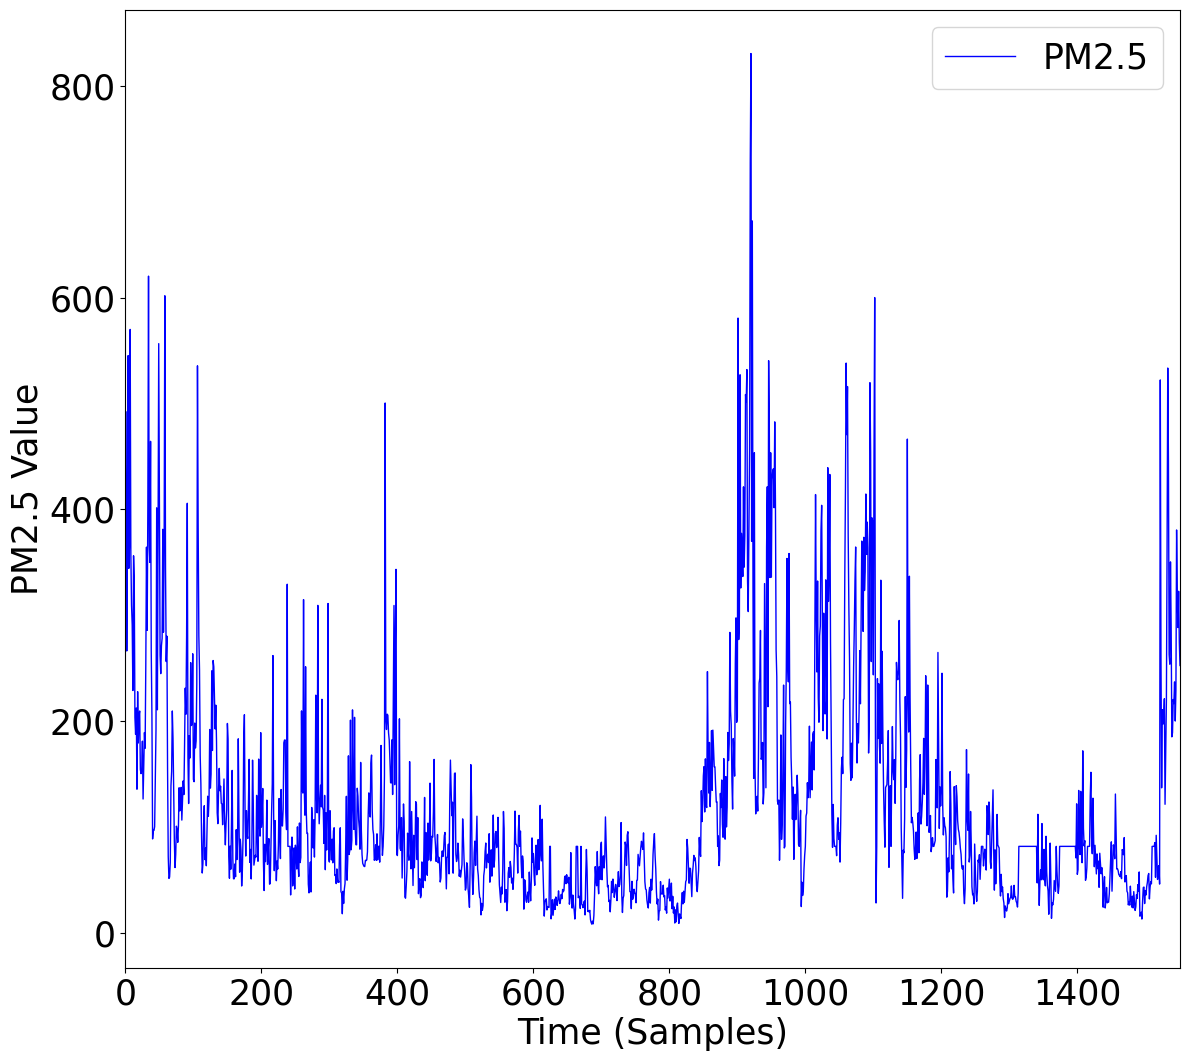

<Figure size 640x480 with 0 Axes>

In [9]:
x_val = np.linspace(1,df_train.shape[0],num = df_train.shape[0])
plot_list = np.array(df_train['PM2.5'].values)
y_val = np.array([(float)(k) for k in plot_list])
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
plt.tick_params(labelsize=25)
params = {'legend.fontsize': 25, 'legend.handlelength': 2}
plt.rcParams.update(params)
surrogate_plot = ax.plot(x_val,y_val,linestyle='-', linewidth= 1, color= 'b', label= 'PM2.5')
ax.set_xlabel('Time (Samples)',size= 25)
ax.set_ylabel('PM2.5 Value', size= 25)
ax.set_xlim([0,np.amax(x_val)])
ax.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()
plt.clf()

Plotting the time-series data for test

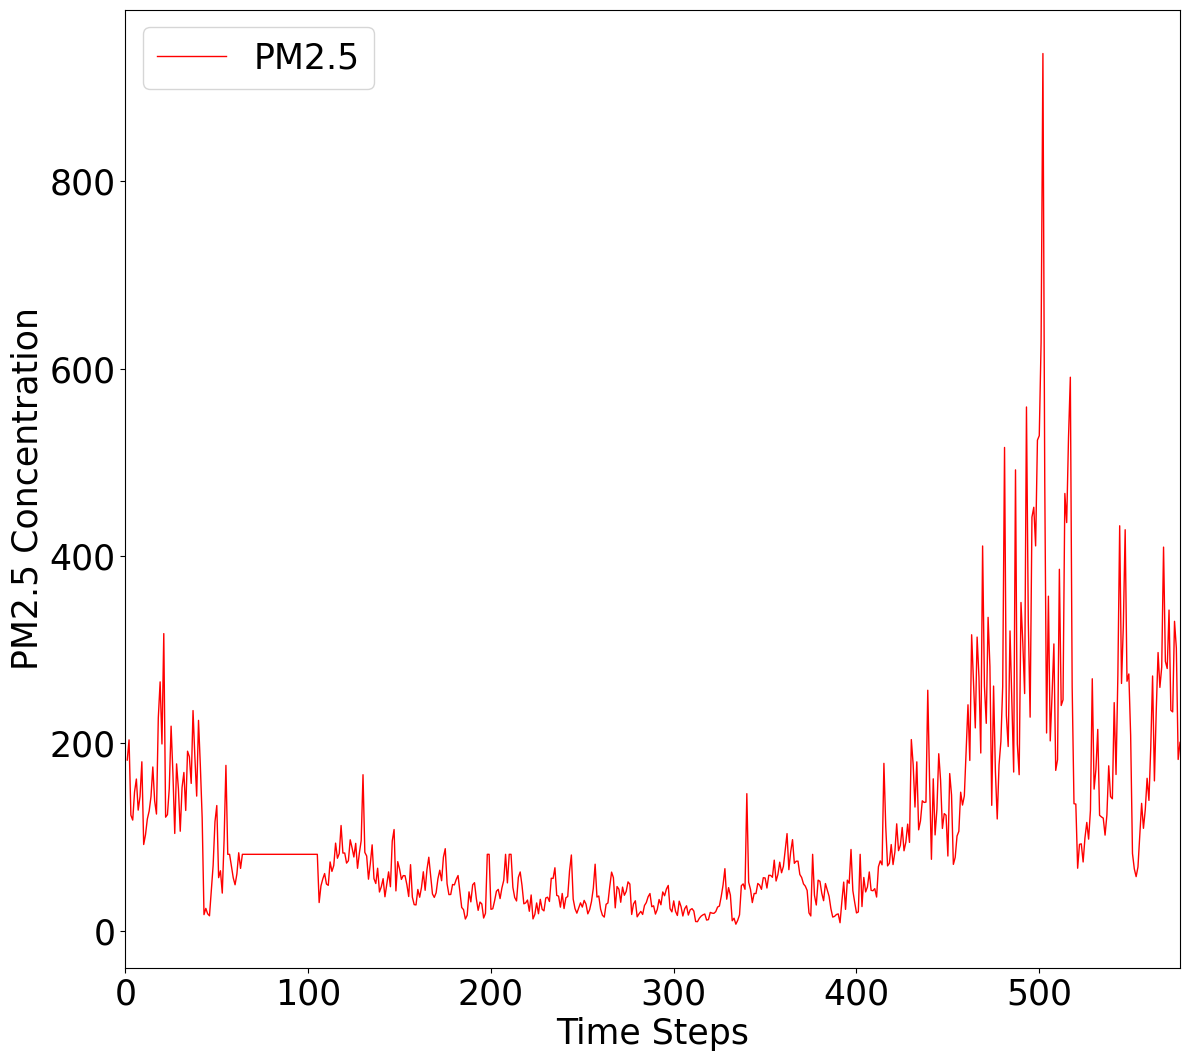

<Figure size 640x480 with 0 Axes>

In [10]:
x_val = np.linspace(1,df_test.shape[0],num = df_test.shape[0])
plot_list = np.array(df_test['PM2.5'].values)
y_val = np.array([(float)(k) for k in plot_list])
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
plt.tick_params(labelsize=25)
params = {'legend.fontsize': 25, 'legend.handlelength': 2}
plt.rcParams.update(params)
surrogate_plot = ax.plot(x_val,y_val,linestyle='-', linewidth= 1, color= 'r', label= 'PM2.5')
ax.set_xlabel('Time Steps',size= 25)
ax.set_ylabel('PM2.5 Concentration', size= 25)
ax.set_xlim([0,np.amax(x_val)])
ax.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()
plt.clf()

In [11]:
dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]
print(values_train.shape,values_test.shape)
n_hours=1
n_out= 1
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values.shape)


(1551, 12) (577, 12)
(2128, 19)


Defining different models and trial experiments

In [12]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array
import datetime

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)






def MODEL_FNN_adam(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    print(train_X.shape)
    train_X=np.reshape(train_X,(train_X.shape[0],n_hours*n_features))
    test_X=np.reshape(test_X,(test_X.shape[0],n_hours*n_features))
    val_X=np.reshape(val_X,(val_X.shape[0],n_hours*n_features))

    model = Sequential()
    model.add(Dense(64, input_dim=train_X.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_out))
    model.compile(loss='mse', optimizer='adam')
    # fit the keras model on the dataset
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    yhat11_inv = ((maxv - minv) * yhat11  + minv)
    test_y_inv = ((maxv - minv) * test_y  + minv)
    print("Predicted = ", yhat11_inv)
    print("Actual = ", test_y_inv)
    err = np.sqrt(((np.sum((yhat11_inv-test_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =",err )
    yhat12 = model.predict(train_X, verbose = 0)
    yhat12_inv = ((maxv - minv) * yhat12  + minv)
    train_y_inv = ((maxv - minv) * train_y  + minv)
    err2 = np.sqrt(((np.sum((yhat12_inv-train_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step for train is =",err2 )
    return err , err2



def MODEL_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_hours,n_features)))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    yhat11_inv = ((maxv - minv) * yhat11  + minv)
    test_y_inv = ((maxv - minv) * test_y  + minv)
    print("Predicted = ", yhat11_inv)
    print("Actual = ", test_y_inv)
    err = np.sqrt(((np.sum((yhat11_inv-test_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =",err )
    yhat12 = model.predict(train_X, verbose = 0)
    yhat12_inv = ((maxv - minv) * yhat12  + minv)
    train_y_inv = ((maxv - minv) * train_y  + minv)
    err2 = np.sqrt(((np.sum((yhat12_inv-train_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step for train is =",err2 )
    return err , err2

def MODEL_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu',input_shape=(n_hours,n_features))))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    # Important note : epochs = 50 for seasonal model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    yhat11_inv = ((maxv - minv) * yhat11  + minv)
    test_y_inv = ((maxv - minv) * test_y  + minv)
    print("Predicted = ", yhat11_inv)
    print("Actual = ", test_y_inv)
    err = np.sqrt(((np.sum((yhat11_inv-test_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =",err )
    yhat12 = model.predict(train_X, verbose = 0)
    yhat12_inv = ((maxv - minv) * yhat12  + minv)
    train_y_inv = ((maxv - minv) * train_y  + minv)
    err2 = np.sqrt(((np.sum((yhat12_inv-train_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step for train is =",err2 )
    return err , err2


def MODEL_EN_DC(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
    val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, activation='relu',input_shape=(n_hours,n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    yhat11_inv = ((maxv - minv) * yhat11  + minv)
    test_y_inv = ((maxv - minv) * test_y  + minv)
    print("Predicted = ", yhat11_inv)
    print("Actual = ", test_y_inv)
    err = np.sqrt(((np.sum((yhat11_inv-test_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =",err )
    yhat12 = model.predict(train_X, verbose = 0)
    yhat12_inv = ((maxv - minv) * yhat12  + minv)
    train_y_inv = ((maxv - minv) * train_y  + minv)
    err2 = np.sqrt(((np.sum((yhat12_inv-train_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step for train is =",err2 )
    return err , err2





n_out_max,n_hour_max= 10,5
out_range=[10]
dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]

values_train = values_train.astype('float32')
values_test = values_test.astype('float32')

Data preparation for training/testing of models

In [13]:
# Run this cell for general analysis of models
dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]

values_train = values_train.astype('float32')
values_test = values_test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
concat = np.concatenate((values_train,values_test),axis = 0)
maxv = max(concat[:,-1])
minv = min(concat[:,-1])
scaled = scaler.fit_transform(concat)
scaled_train = scaled[:values_train.shape[0],:]
scaled_test = scaled[values_train.shape[0]:,:]

Data preparation here is only for 1 month comparison for September using SBD-LSTM


In [14]:
# Run this cell only for seasonal analysis of September
data_july = read_csv('july_test.csv', header=0, index_col=0)
values_july = data_july.values
values_july = values_july[:,1:-6]
values_july = values_july.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
concat = np.concatenate((values_train,values_test,values_july),axis = 0)
maxv = max(concat[:,-1])
minv = min(concat[:,-1])
scaled = scaler.fit_transform(concat)
scaled_train = scaled[:values_train.shape[0],:]
scaled_test = scaled[values_train.shape[0]: (values_train.shape[0] + values_test.shape[0]),:]
scaled_july = scaled[(values_train.shape[0] + values_test.shape[0]):,:]

Training the FNN model using Adam

Feedforward Neural Network (FNN):
* A feedforward neural network architecture.
* Suitable for regression tasks like time series forecasting.

In [ ]:
time1 = time.time()
outfile_adam = open('/content/adam_train.txt','a+')
train_adam = open('/content/adam_train.txt','a+')
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences(scaled_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            err , err2 = MODEL_FNN_adam(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            allres = np.array(err)
            allres2 = np.array(err2)
            for item in allres:
              item = round(item,4)
              outfile_adam.write(str(item) + "  ")
            for item in allres2:
              item = round(item,4)
              train_adam.write(str(item) + "  ")
            #np.savetxt(outfile_adam,  allres  , fmt='%1.4f', newline=' ' )
            #np.savetxt(train_adam,  allres2  , fmt='%1.4f', newline=' ' )
        outfile_adam.write("\n")
        train_adam.write("\n")

outfile_adam.close()
train_adam.close()
time2 = time.time()
print("MODEL_FNN_adam:",time2-time1)


Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  1
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
(1538, 5, 11)
Predicted =  [[ 19.05094   21.166895  21.64496  ...  32.15555   30.294744  30.06862 ]
 [ 48.217678  49.499672  47.937927 ...  49.110233  48.936596  51.19138 ]
 [ 35.71004   37.349667  36.662655 ...  41.83952   40.942368  42.13326 ]
 ...
 [119.61625  120.97482  145.78302  ... 122.22952  131.6366    94.167465]
 [219.10844  172.66934   92.17181  ... 121.85134   71.103836  77.63293 ]
 [288.37885  144.66689  103.14414  ... 136.08688  131.23993  116.277695]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.439

In [ ]:
overall_rmse_test = np.mean(err)
print("Overall RMSE for the test set:", overall_rmse_test)


Overall RMSE for the test set: 1789.6061


In [ ]:
overall_rmse_train = np.mean(err2)
print("Overall RMSE for the training set:", overall_rmse_train)


Overall RMSE for the training set: 1862.1904


Training LSTM model

Long Short-Term Memory (LSTM):
* A type of recurrent neural network (RNN).
* Designed for sequence modeling and time-series data.
* Captures long-range dependencies using memory cells.

In [15]:
time1 = time.time()
outfile_lstm = open('/content/results_lstm.txt','a+')
train_lstm = open('/content/lstm_train.txt','a+')
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences(scaled_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            err , err2=MODEL_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            allres = np.array(err)
            allres2 = np.array(err2)
            for item in allres:
              item = round(item,4)
              outfile_lstm.write(str(item) + "  ")
            for item in allres2:
              item = round(item,4)
              train_lstm.write(str(item) + "  ")
            #np.savetxt(outfile_lstm,  allres  , fmt='%1.4f', newline=' ' )
            #np.savetxt(train_lstm,  allres2  , fmt='%1.4f', newline=' ' )
        outfile_lstm.write("\n")
        train_lstm.write("\n")

outfile_lstm.close()
train_lstm.close()
time2 = time.time()
print("MODEL_LSTM:",time2-time1)


Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  1
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 34.473206  32.43496   36.327568 ...  38.89851   35.91963   35.538147]
 [ 54.20992   56.469257  38.570618 ...  49.463642  33.620388  30.455132]
 [ 54.199646  35.016117  39.75713  ...  32.5711    38.50846   35.743683]
 ...
 [198.76924  190.84195  189.56216  ... 129.06435  126.74071  106.95759 ]
 [191.2494   247.58533  104.84051  ... 173.40196  101.302826  84.62867 ]
 [271.86792  138.82033   95.55371  ...  93.78812   90.05804  145.20604 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1185.8248 1432.6322 1702.3289 

iteration number=  2
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 28.08223   44.859615  42.790096 ...  35.29294   38.479656  38.485146]
 [ 31.64122   68.34703   59.398293 ...  52.4718    49.736725  62.35912 ]
 [ 46.71353   63.71108   56.67435  ...  54.227924  48.91799   66.04405 ]
 ...
 [172.76048  188.3276   204.02844  ... 240.71931  237.06903  139.38222 ]
 [187.55864  200.20305  135.13136  ... 198.43428  147.80302  161.32031 ]
 [253.69867  183.03934  183.33246  ... 185.98485  158.96843  194.20515 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     

Predicted =  [[ 22.373972  36.753185  38.28321  ...  43.210094  40.765396  36.148834]
 [ 38.904938  49.32972   31.039099 ...  65.70774   61.20773   77.0379  ]
 [ 43.019825  58.128407  50.041576 ...  63.088734  81.27356   87.95315 ]
 ...
 [154.48866  128.37299  135.75873  ...  77.649216 113.604294  79.01672 ]
 [179.6215   205.36844  114.329666 ...  83.18791   76.15505   90.36554 ]
 [258.44662  166.04312  105.523384 ...  86.94414   90.708755 124.58736 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1146.2623 1454.5619 1878.5746 

RMSE error using  5  state size to predict  10  step for train is = [1195.2562 1749.2985 1917.3612 1818.9888 1877.5258 1917.901  1906.2483
 1949.7007 1957.2012 2100.9768]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  5
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 46.357716  43.65628   34.38187  ...  46.977077  38.424496  51.524696]
 [ 67.649605  66.91233   49.122684 ...  85.71132   59.28344   74.563126]
 [ 60.9567    59.70994   61.00171  ...  69.11928   70.03555   60.442787]
 ...
 [178.90097  209.8836   184.63281  ... 131.94064  125.557175 113.2322  ]
 [206.05019  252.75261  160.94576  ... 148.78795  111.713875  98.63519 ]
 [273.5905   186.71535  129.70355  ... 119.00459  101.08298  140.12471 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      

RMSE error using  5  state size to predict  10  step for train is = [1346.8151 1889.9835 1931.1826 1838.5514 2016.6145 2082.5212 2227.0642
 2279.2043 2350.9597 2448.1511]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  6
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 38.499695  49.681194  48.124985 ...  55.14952   50.19148   51.259613]
 [ 54.113132  70.03441   78.08717  ...  74.44225   69.24049   76.891106]
 [ 54.755413  64.32207   85.394875 ...  70.461784  72.90864   97.21824 ]
 ...
 [191.12585  229.31781  229.18436  ... 195.83641  214.32722  149.33884 ]
 [261.9107   285.69147  181.10068  ... 141.04628  118.83867  116.566795]
 [342.34634  228.68341  201.60474  ...  95.272224 112.320465 135.77411 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1182.2386 1409.0688 1683.0945 

Predicted =  [[ 29.621798  29.137081  37.15183  ...  41.96658   44.616066  45.94802 ]
 [ 25.0377    33.7127    48.93429  ...  57.6879    54.942116  63.475803]
 [ 25.17182   35.987705  61.364845 ...  60.947033  63.91873   77.08859 ]
 ...
 [138.00568  182.04788  179.02449  ... 186.6261   207.2068   167.10869 ]
 [170.87665  204.45215  114.827576 ... 177.44043  141.24826  114.771355]
 [262.38132  156.63628  125.500984 ... 116.19093  105.18473  139.82658 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1096.3936 1349.306  1810.9064 

RMSE error using  5  state size to predict  10  step for train is = [1278.7164 1859.2491 1894.3425 1890.0703 2042.6783 2119.1926 2154.1902
 2246.3381 2401.8276 2475.122 ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  9
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 36.43844   50.987225  46.276535 ...  45.481216  51.592747  54.737152]
 [ 53.559494  84.79999   76.96273  ...  54.738003  58.02811   72.88011 ]
 [ 50.921204  70.41616   66.630035 ...  43.673454  37.28652   63.512024]
 ...
 [176.34439  191.49104  214.25322  ... 156.61153  218.77562  172.73532 ]
 [181.90968  228.58131  124.237946 ... 147.01472  121.961266 134.20238 ]
 [252.10452  195.29347  113.1253   ... 122.70907  129.40106  163.19228 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      

RMSE error using  5  state size to predict  10  step for train is = [1201.5603 1708.6376 1807.1461 1827.2122 1921.3313 1903.0055 1923.1893
 2001.1288 2003.1128 2154.0525]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  10
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 35.530083  28.233738  33.543003 ...  50.727406  49.787674  50.473907]
 [ 55.89008   63.725048  64.916214 ... 114.19335  128.87364  126.534035]
 [ 45.95562   43.868702  60.851917 ...  97.080734 117.15828  115.565346]
 ...
 [182.18822  275.9557   299.6949   ... 205.80336  220.47266  124.56952 ]
 [175.73714  266.86026  158.3413   ... 256.9762   164.43703  167.32487 ]
 [307.26773  217.46672  169.49565  ... 185.00287  135.44075  183.5086  ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1144.5228 1464.5198 1557.0817 

Predicted =  [[ 26.2366    35.446735  47.662636 ...  40.55097   46.460167  54.29708 ]
 [ 36.072517  37.459106  57.152275 ...  50.538643  64.21047   65.960884]
 [ 30.181467  30.727482  54.061115 ...  44.327316  56.034153  61.950375]
 ...
 [191.79814  239.67165  236.78546  ... 146.2235   128.80911   61.59572 ]
 [192.33792  278.95312  188.7284   ... 159.6022    94.24737   80.490166]
 [251.05276  174.1957   164.82753  ... 132.731    109.027596 151.16158 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1154.396  1359.5973 1512.6355 

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  13
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 46.693768   55.92298    51.985718  ...  65.91214    66.35356
   67.58923  ]
 [ 46.95197    69.70075    70.32322   ...  62.38581    65.26735
   91.89838  ]
 [ 43.97074    35.3054     55.016235  ...  37.18811    54.367245
   80.422485 ]
 ...
 [132.1201    125.16729    80.032936  ...  79.41932    71.09072
   52.36297  ]
 [155.5265    180.3527    120.11302   ...  56.75682    30.55585
   41.228634 ]
 [205.64633   144.45189   116.36914   ...  21.666384   -2.2249742
   36.47398  ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  st

Predicted =  [[ 48.92617   44.966366  46.7367   ...  49.64308   53.756184  53.400253]
 [ 65.7968    72.53213   79.864685 ...  78.90797   83.61469   72.82697 ]
 [ 48.662975  49.286736  59.727276 ...  66.46401   88.028786  81.58978 ]
 ...
 [202.36165  213.64783  202.48412  ... 110.59793  137.51051   93.60336 ]
 [187.31592  227.07755  129.33777  ... 120.25338   93.76045   95.60597 ]
 [245.44006  181.14192  139.31915  ... 128.08217  119.42445  136.01039 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1118.1498 1381.595  1613.7872 

Predicted =  [[ 26.036814  34.28884   34.754017 ...  44.082928  44.375546  49.39889 ]
 [ 48.583103  59.580807  70.827156 ...  51.997623  63.03367   54.75034 ]
 [ 45.701794  46.491447  60.83014  ...  54.922623  59.44628   61.297974]
 ...
 [155.05801  179.59068  153.71242  ...  96.22996   96.130035  61.58601 ]
 [182.22987  210.00322  117.093704 ...  94.80682   72.97962   99.65176 ]
 [280.5038   177.9859   103.09141  ...  45.959263  52.59798  128.25284 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1039.5419 1473.2682 1856.2888 

RMSE error using  5  state size to predict  10  step for train is = [1478.725  1838.9504 2032.8077 2138.8271 2352.3398 2299.793  2293.335
 2202.5798 1957.9093 2117.4783]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  17
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 22.308489  38.759243  42.29737  ...  53.876278  50.440487  53.980873]
 [ 59.526665  57.6002    41.1009   ...  69.29754   61.31687   67.177635]
 [ 43.825615  41.644653  38.94416  ...  76.88389   61.522766  67.82778 ]
 ...
 [141.51598  164.04402  171.36484  ... 138.13666  155.93419   95.29927 ]
 [203.24171  214.68471  110.65191  ... 127.32465   89.94378   76.65961 ]
 [284.62332  158.54051  119.26727  ...  94.06129   65.76529  117.45158 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1179.3418 1346.7482 1670.2175 

RMSE error using  5  state size to predict  10  step for train is = [1177.6218 1740.887  1878.4174 1910.9503 2031.4574 2076.6892 2135.4983
 2185.1824 2121.2358 2187.9148]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  19
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 26.584776  40.990803  39.341248 ...  33.65469   37.383675  40.3694  ]
 [ 34.53552   58.814003  49.700874 ...  80.68784   70.22756   99.9571  ]
 [ 30.149761  44.34438   49.152443 ...  81.41762   71.82276  100.631035]
 ...
 [203.09738  279.17136  277.44385  ... 127.09779  129.41455   82.45768 ]
 [182.54855  207.71704  129.3154   ... 140.42308  122.32077  153.84018 ]
 [264.645    211.08495  186.72556  ... 130.83646  114.14617  149.86273 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1142.3502 1378.649  1506.0018 

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  21
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 33.841915  52.02795   44.895218 ...  38.637814  44.7193    52.166077]
 [ 56.234024  70.12994   55.7715   ...  57.555626  57.53619   65.59369 ]
 [ 50.565895  56.873764  51.95827  ...  56.44098   54.863457  61.822285]
 ...
 [156.65193  158.27148  172.98157  ... 147.26805  166.01173  138.46806 ]
 [161.94255  179.87239   95.45798  ... 149.3261   110.097115 117.94348 ]
 [224.60869  139.22148  102.91894  ... 109.025665 103.84034  136.5824  ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1209.4424 1533.6687 1802.1431 

(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 20.975136  38.75202   45.860405 ...  42.594162  50.11408   50.81143 ]
 [ 37.685944  63.386517  58.431477 ...  73.88122   82.25877   81.38143 ]
 [ 41.43655   50.376232  47.273438 ...  81.37841   80.63399   94.18163 ]
 ...
 [186.43211  197.08656  170.19913  ... 177.29536  180.35321  118.0722  ]
 [213.81067  201.90671  136.47665  ... 146.32065  133.65724  128.88219 ]
 [271.28885  166.47206  130.33049  ...  96.04143  103.46032   96.39183 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 

RMSE error using  5  state size to predict  10  step for train is = [1207.4724 1657.8145 1805.1877 1799.9315 1979.955  1977.2098 1999.0115
 1928.2208 1953.0736 2052.3867]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  24
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 32.712727  36.36019   37.491714 ...  35.434803  45.888836  48.34927 ]
 [ 48.73241   47.073574  41.840115 ...  48.726284  57.622616  56.105385]
 [ 46.575905  45.69396   42.046154 ...  44.608833  48.494156  49.79036 ]
 ...
 [178.98915  170.18173  179.27058  ... 145.97404  164.18188  139.32214 ]
 [192.13892  233.13136  134.53453  ... 152.44212   98.63217  111.29525 ]
 [240.79518  166.63254  192.6879   ... 141.83638  104.359695 131.47066 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31     

RMSE error using  5  state size to predict  10  step for train is = [1417.1791 1868.2603 1820.6084 1800.1578 1951.9236 2149.3054 2293.1326
 2178.882  2063.6548 2086.435 ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  25
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 28.549711  36.34123   24.538929 ...  39.404324  42.11534   46.809155]
 [ 42.142796  62.007053  58.574455 ...  95.93768   79.09853   86.748795]
 [ 43.483482  58.649494  58.840637 ...  90.226166  77.30259   83.74935 ]
 ...
 [191.02095  241.59834  250.2438   ... 187.79198  195.93752  141.54704 ]
 [206.72943  240.28395  146.8894   ... 147.32426  120.930145 107.43706 ]
 [288.056    207.5502   186.0593   ... 137.13979  108.289246 138.52562 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31     

RMSE error using  5  state size to predict  10  step for train is = [2016.3992 2495.3325 2449.648  2195.2708 2421.3853 2445.5286 2433.3118
 2721.8406 2730.923  2786.9265]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  26
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)


Predicted =  [[ 19.630602  31.527626  21.489025 ...  49.69448   34.732933  40.442856]
 [ 24.422651  49.31621   31.842432 ...  68.17176   46.476322  52.41649 ]
 [ 17.24757   40.502716  39.40208  ...  58.99028   42.166862  39.45839 ]
 ...
 [142.12805  199.55682  165.13783  ... 139.43694  122.891624  89.68092 ]
 [206.99167  190.45425  127.03694  ... 158.89035  128.19792  107.473885]
 [278.6311   192.01268  127.076    ... 171.17009  139.31662  140.7581  ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1220.963  1446.7782 1748.1389 

Predicted =  [[ 34.648148  35.307     26.364223 ...  49.514328  59.699646  57.041935]
 [ 51.387947  69.06891   37.708447 ...  76.49327   66.62772   75.352585]
 [ 33.02152   30.40406   29.020908 ...  58.0067    61.786144  58.93986 ]
 ...
 [182.77802  170.0846   193.44536  ... 204.74626  173.15433   98.32411 ]
 [193.98915  257.5693   149.71225  ... 208.87215  127.09599  114.59384 ]
 [268.9498   184.34662  164.5698   ... 144.95634  113.23181  180.18472 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1214.8494 1446.7146 1790.8835 

Predicted =  [[ 17.179499  32.373802  32.2311   ...  57.949226  54.76057   57.746044]
 [ 26.791864  53.06636   41.22871  ...  69.86416   62.020664  70.565186]
 [ 33.121487  32.84679   32.044342 ...  45.688572  50.705433  54.284725]
 ...
 [180.34258  161.75542  160.92511  ...  62.68348  101.32189   60.89613 ]
 [195.11761  196.69038  114.16646  ... 132.46075   94.976456  98.16106 ]
 [256.1639   157.35147  119.404495 ... 112.40158  112.98584  135.4222  ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31      44.43     ...  20.619999  16.219997  31.500002]
 [ 37.31      44.43      48.31     ...  16.219997  31.500002  25.720001]
 ...
 [259.68997  281.5      409.43997  ... 233.55997  330.22     301.68997 ]
 [281.5      409.43997  287.5      ... 330.22     301.68997  182.77998 ]
 [409.43997  287.5      279.80997  ... 301.68997  182.77998  200.99998 ]]
RMSE error using  5  state size to predict  10  step is = [1153.1464 1453.0154 1680.0834 

RMSE error using  5  state size to predict  10  step for train is = [1196.5238 1696.7909 1882.8589 1843.8616 1995.3656 1937.4478 1887.4768
 1910.2395 1978.2601 2023.2749]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  5 iteration number=  30
(564, 5, 11) (564, 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (1538, 5, 11) (1538, 10) (276, 5, 11) (276, 10)
val X, val y (288, 5, 11) (288, 10)
Predicted =  [[ 31.84219   42.345207  45.38109  ...  48.3953    48.230213  46.63417 ]
 [ 49.721203  73.03224   68.39169  ...  74.47134   79.37618   77.21642 ]
 [ 49.563034  50.02663   48.30439  ...  33.072453  52.019463  72.708725]
 ...
 [178.18211  214.00014  225.02167  ... 127.27477  129.38768   85.68665 ]
 [160.80818  223.22882  151.47656  ... 146.09622  102.039116 109.70427 ]
 [227.9692   188.69646  129.60617  ...  96.04819   77.1813   111.08201 ]]
Actual =  [[ 27.659998  41.38      37.31     ...  31.81      20.619999  16.219997]
 [ 41.38      37.31     

In [16]:
overall_rmse_test = np.mean(err)
print("Overall RMSE for the test set:", overall_rmse_test)

Overall RMSE for the test set: 1815.1111


In [17]:
overall_rmse_train = np.mean(err2)
print("Overall RMSE for the training set:", overall_rmse_train)

Overall RMSE for the training set: 1832.0931


Training Bi-LSTM model

> Note: For seasonal model the split interval for validation split will be after 365 data points.

Bidirectional LSTM (Bi-LSTM):
* Processes input sequences in both forward and backward directions.
* Enhances context capture by considering past and future information.

In [ ]:
outfile_bi_lstm = open('results/AnandVihar/results_bi_lstm.txt','a+')
train_bi_lstm = open('results/AnandVihar/bi_lstm_train.txt','a+')
time1 = time.time()
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences(scaled_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            """
            Uncomment below two lines for Seasonal Analysis and comment above two lines
            """
            #test_X, test_y = val_X[365:,:,:],val_y[365:,:]
            #val_X, val_y = val_X[0:365,:,:],val_y[0:365,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            err , err2=MODEL_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            allres = np.array(err)
            allres2 = np.array(err2)
            for item in allres:
              item = round(item,4)
              outfile_bi_lstm.write(str(item) + "  ")
            for item in allres2:
              item = round(item,4)
              train_bi_lstm.write(str(item) + "  ")
            #np.savetxt(outfile_bi_lstm,  allres  , fmt='%1.4f', newline=' ' )
            #np.savetxt(train_bi_lstm,  allres2  , fmt='%1.4f', newline=' ' )
        outfile_bi_lstm.write("\n")
        train_bi_lstm.write("\n")

outfile_bi_lstm.close()
train_bi_lstm.close()
time2 = time.time()
print("MODEL_Bi_LSTM:",time2-time1)


Training Encoder-Decoder LSTM model

Encoder-Decoder LSTM:
* Consists of an encoder and a decoder (two LSTM networks).
* Encoder compresses input sequences into a context vector.
* Decoder generates output sequences based on the context vector.

In [ ]:
outfile_en_dc = open('results/AnandVihar/results_en_dc.txt','a+')
train_en_dc = open('results/AnandVihar/en_dc_train.txt','a+')
time1 = time.time()
out_range=[10]
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences(scaled_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            err,err2 = MODEL_EN_DC(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            allres = np.array([item[0] for item in err])
            allres2 = np.array([item[0] for item in err2])
            for item in allres:
              item = round(item,4)
              outfile_en_dc.write(str(item) + "  ")
            for item in allres2:
              item = round(item,4)
              train_en_dc.write(str(item) + "  ")
            #np.savetxt(outfile_en_dc,  allres  , fmt='%1.4f', newline=' ' )
            #np.savetxt(train_en_dc,  allres2  , fmt='%1.4f', newline=' ' )
        outfile_en_dc.write("\n")
        train_en_dc.write("\n")

outfile_en_dc.close()
train_en_dc.close()
time2 = time.time()
print("MODEL_ENC_DCD:",time2-time1)


Plotting different bars:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def show_results(r,method):
    x = datetime.datetime.now()
    print("r = ", r)
    u=np.mean(r,axis=0)
    sigma=np.std(r,axis=0)
    lower_bar= u-1.96*(sigma/(np.sqrt(1)))
    upper_bar= u+1.96*(sigma/(np.sqrt(1)))
    barWidth = 0.3
    bars1=u
    rl= np.arange(len(bars1))+1
    plt.bar(rl, bars1, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma/(np.sqrt(r.shape[0]))), capsize=7, label=method+' with using 10 multivariate steps for 30 iterations')
    plt.ylabel('mean of normalized RMSE for 30 iterations')
    plt.xlabel('Number of steps')
    plt.legend()
    plt.show()


In [ ]:

ladam = []
# change file directory for different stations accordingly
file1 = open('results/AnandVihar/results_adam.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  ladam.append([float(li[k]) for k in range(10)])

dADAM=np.array(ladam)
print(dADAM.shape)
show_results(dADAM,'fnn_ADAM')


In [ ]:

dLSTM = []
file1 = open('results/AnandVihar/results_lstm.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dLSTM.append([float(li[k]) for k in range(10)])

dLSTM=np.array(dLSTM)
print(dLSTM.shape)

show_results(dLSTM,'LSTM')

In [ ]:
dEN = []
file1 = open('results/AnandVihar/results_en_dc.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dEN.append([float(li[k]) for k in range(10)])
dEN=np.array(dEN)
print(dEN.shape)
show_results(dEN,'Encoder-Decoder')

In [ ]:
dBI = []
file1 = open('results/AnandVihar/results_bi_lstm.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dBI.append([float(li[k]) for k in range(10)])
dBI=np.array(dBI)
print(dBI.shape)
show_results(dBI,'Bi directional LSTM')

In [ ]:
def show_results_Combined(r1,r2,r3,r4):
    x = datetime.datetime.now()
    print(r1.shape)
    u1=np.mean(r1,axis=0)
    u2=np.mean(r2,axis=0)
    u3=np.mean(r3,axis=0)
    u4=np.mean(r4,axis=0)
    sigma1=np.std(r1,axis=0)
    sigma2=np.std(r2,axis=0)
    sigma3=np.std(r3,axis=0)
    sigma4=np.std(r4,axis=0)
    barWidth = 0.17
    bars1=u1
    bars2=u2
    bars3=u3
    bars4=u4
    ra1= np.arange(len(bars1))+1
    ra2 = [y + barWidth for y in ra1]
    ra3 = [y + barWidth for y in ra2]
    ra4 = [y + barWidth for y in ra3]
    plt.bar(ra1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=1.96*(sigma1/(np.sqrt(r1.shape[0]))), capsize=7, label='FNN-ADAM')
    plt.bar(ra2, bars2, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=1.96*(sigma2/(np.sqrt(r2.shape[0]))), capsize=7, label='LSTM')
    plt.bar(ra3, bars3, width = barWidth, color = 'green', edgecolor = 'black', yerr=1.96*(sigma3/(np.sqrt(r3.shape[0]))), capsize=7, label='BD-LSTM')
    plt.bar(ra4, bars4, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma4/(np.sqrt(r4.shape[0]))), capsize=7, label='ED-LSTM')
    plt.ylabel('mean of RMSE for 30 iterations')
    plt.xlabel('Number of steps')
    plt.legend()
    plt.show()
show_results_Combined(dADAM,dLSTM,dBI,dEN)
## Change the fontsize of legends according to convenience

In [ ]:
import plotly.graph_objects as go

u1=np.mean(dADAM,axis=0)
u2=np.mean(dLSTM,axis=0)
u3=np.mean(dEN,axis=0)
u4=np.mean(dBI,axis=0)
sigma1=np.array([1.96*(np.std(dADAM[:,k])/(np.sqrt(dADAM[:,k].shape[0]))) for k in range(10)])
sigma2=np.array([1.96*(np.std(dLSTM[:,k])/(np.sqrt(dLSTM[:,k].shape[0]))) for k in range(10)])
sigma3=np.array([1.96*(np.std(dEN[:,k])/(np.sqrt(dEN[:,k].shape[0]))) for k in range(10)])
sigma4=np.array([1.96*(np.std(dBI[:,k])/(np.sqrt(dBI[:,k].shape[0]))) for k in range(10)])
fig = go.Figure()
df=pd.DataFrame()
df['ADAM']=u1
df['LSTM']=u2
df['EN']=u3
df['BI']=u4
df['steps']=[1,2,3,4,5,6,7,8,9,10]
fig.add_trace(go.Bar(x=df['steps'],
                y=df['ADAM'],
                     error_y=dict(type='data', array=sigma1),
                name='FNN-ADAM',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=df['steps'],
                y=df['LSTM'],
                error_y=dict(type='data', array=sigma2),
                name='LSTM',
                marker_color='rgb(200,125,150)'
                ))
fig.add_trace(go.Bar(x=df['steps'],
                y=df['EN'],
                error_y=dict(type='data', array=sigma3),
                name='ED-LSTM',
                marker_color='rgb(13, 255, 20)'
                ))
fig.add_trace(go.Bar(x=df['steps'],
                y=df['BI'],
                error_y=dict(type='data', array=sigma4),
                name='BD-LSTM',
                marker_color='rgb(255, 10, 10)'
                ))

fig.update_layout(
    #title='mean of RMSE for 30 iterations' ,
    width = 800,
    xaxis_tickfont_size=20,
    xaxis=dict(
        title='Step Size',
        titlefont_size=20,
        tickfont_size=20,
    ),
    yaxis=dict(
        title='RMSE(Mean)',
        titlefont_size=20,
        tickfont_size=20,
    ),
    legend=dict(
        x=0,
        y=1.0,
        font=dict(
            size=18
        ),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.25, # gap between bars of adjacent location coordinates.
    bargroupgap=0.05# gap between bars of the same location coordinate.


)
fig.show()

Data Preparation 1: Random Shuffling

The training data is randomly shuffled to enhance model performance.

In [ ]:

def Shuffled_BiLSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(n_hours,n_features))))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=64, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle= True)
    yhat11 = model.predict(test_X, verbose=0)
    yhat11_inv = ((maxv - minv) * yhat11  + minv)
    test_y_inv = ((maxv - minv) * test_y  + minv)
    print("Predicted = ", yhat11_inv)
    print("Actual = ", test_y_inv)
    err = np.sqrt(((np.sum((yhat11_inv-test_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =",err )
    yhat12 = model.predict(train_X, verbose = 0)
    yhat12_inv = ((maxv - minv) * yhat12  + minv)
    train_y_inv = ((maxv - minv) * train_y  + minv)
    err2 = np.sqrt(((np.sum((yhat12_inv-train_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step for train is =",err2 )
    return err , err2


time1 = time.time()
outfile_bilstm_shuffled = open('results/AnandVihar/results_bilstm_shuffled.txt','a+')
train_shuffled_bilstm = open('results/AnandVihar/bilstm_shuffled_train.txt','a+')
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences(scaled_test,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            print("n_features = ",n_features)
            err , err2= Shuffled_BiLSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            allres = np.array(err)
            allres2 = np.array(err2)
            for item in allres:
              item = round(item,4)
              outfile_bilstm_shuffled.write(str(item) + "  ")
            for item in allres2:
              item = round(item,4)
              train_shuffled_bilstm.write(str(item) + "  ")
            #np.savetxt(outfile_bilstm_shuffled,  allres  , fmt='%1.4f', newline=' ' )
            #np.savetxt(train_shuffled_bilstm,  allres2  , fmt='%1.4f', newline=' ' )
        outfile_bilstm_shuffled.write("\n")
        train_shuffled_bilstm.write("\n")

outfile_bilstm_shuffled.close()
train_shuffled_bilstm.close()
time2 = time.time()
print("MODEL_time:",time2-time1)
#np.savetxt("10i_"+str(result.shape[1])+"o_FNN_adam_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")


Data Preparation 2: Univariate vs Multivariate Analysis using our best model- Bi-LSTM

In [ ]:

def split_sequences_univariate(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern

        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix-1:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def MODEL_Univariate_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(n_hours,n_features))))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(train_X, train_y, epochs=1000, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    yhat11_inv = ((maxv - minv) * yhat11  + minv)
    test_y_inv = ((maxv - minv) * test_y  + minv)
    print("Predicted = ", yhat11_inv)
    print("Actual = ", test_y_inv)
    err = np.sqrt(((np.sum((yhat11_inv-test_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =",err )
    yhat12 = model.predict(train_X, verbose = 0)
    yhat12_inv = ((maxv - minv) * yhat12  + minv)
    train_y_inv = ((maxv - minv) * train_y  + minv)
    err2 = np.sqrt(((np.sum((yhat12_inv-train_y_inv)**2,axis=0))))
    print("RMSE error using ",n_hours," state size to predict ",n_out," step for train is =",err2 )
    return err , err2



dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,-7]
values_test=values_test[:,-7]
values_train = values_train.astype('float32')
values_test = values_test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
concat = np.concatenate((values_train,values_test),axis = 0)
print(concat.shape)
maxv = max(concat)
minv = min(concat)
scaled = (concat-minv)/(maxv-minv)
scaled_train = scaled[:values_train.shape[0]]
scaled_test = scaled[values_train.shape[0]:]
outfile_bi_lstm = open('results/AnandVihar/results_bi_lstm_univariate.txt','a+')
train_bi_lstm = open('results/AnandVihar/bi_lstm_univarate_train.txt','a+')
time1 = time.time()
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences_univariate(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences_univariate(scaled_test,n_hours,n_out)
            val_X = val_X.reshape(val_X.shape[0] , val_X.shape[1] , 1)
            train_X = train_X.reshape(train_X.shape[0] , train_X.shape[1] , 1)
            print(val_X.shape,val_y.shape)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = 1
            err , err2=MODEL_Univariate_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            allres = np.array(err)
            allres2 = np.array(err2)
            for item in allres:
              item = round(item,4)
              outfile_bi_lstm.write(str(item) + "  ")
            for item in allres2:
              item = round(item,4)
              train_bi_lstm.write(str(item) + "  ")
            #np.savetxt(outfile_bi_lstm,  allres  , fmt='%1.4f', newline=' ' )
            #np.savetxt(train_bi_lstm,  allres2  , fmt='%1.4f', newline=' ' )
        outfile_bi_lstm.write("\n")
        train_bi_lstm.write("\n")

outfile_bi_lstm.close()
train_bi_lstm.close()

time2 = time.time()
print("MODEL_Bi_LSTM:",time2-time1)

In [ ]:
shuffled = []
file1 = open('results/AnandVihar/results_bilstm_shuffled.txt','r')
#file1 = open('results/AnandVihar/1_shuffled_test.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  shuffled.append([float(li[k]) for k in range(10)])
shuffled = np.array(shuffled)
flat_shuffled = np.ravel(shuffled , order = 'F')
print("Mean = ", np.mean(flat_shuffled))
print("Error = ", 1.96*(np.std(flat_shuffled)/(np.sqrt(flat_shuffled.shape[0]))))

Plotting for results of different models

In [ ]:
##Get the test results
#FNN-ADAM
dADAM_train = []
file1 = open('results/AnandVihar/adam_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dADAM_train.append([float(li[k]) for k in range(10)])
dADAM_train=np.array(dADAM_train)

#LSTM
dLSTM_train = []
file1 = open('results/AnandVihar/lstm_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dLSTM_train.append([float(li[k]) for k in range(10)])
dLSTM_train=np.array(dLSTM_train)

#ED-LSTM
dEN_train = []
file1 = open('results/AnandVihar/en_dc_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dEN_train.append([float(li[k]) for k in range(10)])
dEN_train=np.array(dEN_train)

#BD-LSTM
dBI_train = []
file1 = open('results/AnandVihar/bi_lstm_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dBI_train.append([float(li[k]) for k in range(10)])
dBI_train=np.array(dBI_train)

#BD-LSTM*
shuffled_train = []
file1 = open('results/AnandVihar/bilstm_shuffled_train.txt','r')
#file1 = open('results/AnandVihar/1_shuffled_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  shuffled_train.append([float(li[k]) for k in range(10)])
shuffled_train=np.array(shuffled_train)

#UBD-LSTM
UBD_train = []
file1 = open('results/AnandVihar/bi_lstm_univarate_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  UBD_train.append([float(li[k]) for k in range(10)])
UBD_train=np.array(UBD_train)
#SBD-LSTM
SBD_train = []
file1 = open('results/AnandVihar/seasonal_bi_lstm_train.txt','r')
#file1 = open('results/AnandVihar/1_seasonal_train.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  SBD_train.append([float(li[k]) for k in range(10)])
SBD_train=np.array(SBD_train)

In [ ]:
## Corresponding Test RMSE with Mean and Error across 10 horizons
#flat_dSGD = np.ravel(dSGD , order = 'F')
flat_dADAM = np.ravel(dADAM , order = 'F')
flat_dLSTM = np.ravel(dLSTM , order = 'F')
flat_dEN = np.ravel(dEN , order = 'F')
flat_dBI = np.ravel(dBI , order = 'F')

dBI_univ = []
file1 = open('results/AnandVihar/results_bi_lstm_univariate.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dBI_univ.append([float(li[k]) for k in range(10)])
dBI_univ = np.array(dBI_univ)
flat_dBI_univ = np.ravel(dBI_univ , order = 'F')

dBI_season = []
file1 = open('results/AnandVihar/result_seasonal_bi_lstm.txt','r')
#file1 = open('results/AnandVihar/1_seasonal_test.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:10]
  dBI_season.append([float(li[k]) for k in range(10)])
dBI_season = np.array(dBI_season)
flat_dBI_season = np.ravel(dBI_season , order = 'F')

#m1 = np.mean(flat_dSGD)
m2 = np.mean(flat_dADAM)
m3 = np.mean(flat_dLSTM)
m4 = np.mean(flat_dEN)
m5 = np.mean(flat_dBI)
m6 = np.mean(flat_dBI_univ)
m7 = np.mean(flat_shuffled)
m8 = np.mean(flat_dBI_season)

#s1 = 1.96*(np.std(flat_dSGD)/(np.sqrt(flat_dSGD.shape[0])))
s2 = 1.96*(np.std(flat_dADAM)/(np.sqrt(flat_dADAM.shape[0])))
s3 = 1.96*(np.std(flat_dLSTM)/(np.sqrt(flat_dLSTM.shape[0])))
s4 = 1.96*(np.std(flat_dEN)/(np.sqrt(flat_dEN.shape[0])))
s5 = 1.96*(np.std(flat_dBI)/(np.sqrt(flat_dBI.shape[0])))
s6 = 1.96*(np.std(flat_dBI_univ)/(np.sqrt(flat_dBI_univ.shape[0])))
s7 = 1.96*(np.std(flat_shuffled)/(np.sqrt(flat_shuffled.shape[0])))
s8 = 1.96*(np.std(flat_dBI_season)/(np.sqrt(flat_dBI_season.shape[0])))

## Corresponding Train RMSE with Mean and Error across 10 horizons
flat_dADAM_train = np.ravel(dADAM_train , order = 'F')
flat_dLSTM_train = np.ravel(dLSTM_train , order = 'F')
flat_dEN_train = np.ravel(dEN_train , order = 'F')
flat_dBI_train = np.ravel(dBI_train , order = 'F')
flat_shuffled_train = np.ravel(shuffled_train , order = 'F')
flat_UBD_train = np.ravel(UBD_train , order = 'F')
flat_SBD_train = np.ravel(SBD_train , order = 'F')

n2 = np.mean(flat_dADAM_train)
n3 = np.mean(flat_dLSTM_train)
n4 = np.mean(flat_dEN_train)
n5 = np.mean(flat_dBI_train)
n6 = np.mean(flat_UBD_train)
n7 = np.mean(flat_shuffled_train)
n8 = np.mean(flat_SBD_train)

t2 = 1.96*(np.std(flat_dADAM_train)/(np.sqrt(flat_dADAM_train.shape[0])))
t3 = 1.96*(np.std(flat_dLSTM_train)/(np.sqrt(flat_dLSTM_train.shape[0])))
t4 = 1.96*(np.std(flat_dEN_train)/(np.sqrt(flat_dEN_train.shape[0])))
t5 = 1.96*(np.std(flat_dBI_train)/(np.sqrt(flat_dBI_train.shape[0])))
t6 = 1.96*(np.std(flat_UBD_train)/(np.sqrt(flat_UBD_train.shape[0])))
t7 = 1.96*(np.std(flat_shuffled_train)/(np.sqrt(flat_shuffled_train.shape[0])))
t8 = 1.96*(np.std(flat_SBD_train)/(np.sqrt(flat_SBD_train.shape[0])))

X = ['Train','Test']
fig = go.Figure()

fig.add_trace(go.Bar(x= X,
                y=np.array([n2,m2]),
                     error_y=dict(type='data', array= np.array([t2,s2])),
                name='FNN-ADAM',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x= X,
                y= np.array([n3,m3]),
                error_y=dict(type='data', array= np.array([t3,s3])),
                name='LSTM',
                marker_color='rgb(200,125,150)'
                ))
fig.add_trace(go.Bar(x=X,
                y= np.array([n4,m4]),
                error_y=dict(type='data', array= np.array([t4,s4])),
                name='ED-LSTM',
                marker_color='rgb(13, 255, 20)'
                ))
fig.add_trace(go.Bar(x=X,
                y= np.array([n5,m5]),
                error_y=dict(type='data', array= np.array([t5,s5])),
                name='BD-LSTM',
                marker_color='rgb(255, 10, 10)'
                ))


fig.update_layout(
    #title='Mean and Error of RMSE for 10 prediction horizons' ,
    xaxis_tickfont_size=20,
    width = 750,
    yaxis=dict(
        title='RMSE(Mean)',
        titlefont_size=20,
        tickfont_size=20,
    ),
    legend=dict(
        x=0.94,
        y=1.0,
        font = dict(size = 18),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.2, # gap between bars of adjacent location coordinates.
    bargroupgap=0.05# gap between bars of the same location coordinate.

)
fig.show()

In [ ]:
X = ['Train','Test']
fig = go.Figure()
fig.add_trace(go.Bar(x=X,
                y= np.array([n5,m5]),
                error_y=dict(type='data', array= np.array([t5,s5])),
                name='BD-LSTM',
                marker_color='rgb(255, 10, 10)'
                ))
fig.add_trace(go.Bar(x= X,
                y=np.array([n7,m7]),
                     error_y=dict(type='data', array= np.array([t7,s7])),
                name='BD-LSTM*',
                marker_color='#FF851B'
                ))
fig.add_trace(go.Bar(x=X,
                y= np.array([n6,m6]),
                error_y=dict(type='data', array= np.array([t6,s6])),
                name='UBD-LSTM',
                marker_color='lightseagreen'
                ))

fig.add_trace(go.Bar(x=X,
                y= np.array([n8,m8]),
                error_y=dict(type='data', array= np.array([t8,s8])),
                name='SBD-LSTM',
                marker_color='darkblue'
                ))


fig.update_layout(
    #title='Mean and Error of RMSE for 10 prediction horizons' ,
    xaxis_tickfont_size=20,
    width = 700,
    yaxis=dict(
        title='RMSE(Mean)',
        titlefont_size=20,
        tickfont_size=20,
    ),
    legend=dict(
        x=0.94,
        y=1.0,
        font = dict(size = 18),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.2, # gap between bars of adjacent location coordinates.
    bargroupgap=0.05# gap between bars of the same location coordinate.

)
fig.show()

Table for all time steps


In [ ]:
row_train_mean = [n2,n3,n4,n5,n7,n6,n8,t2,t3,t4,t5,t7,t6,t8]
row_test_mean = [m2,m3,m4,m5,m7,m6,m8,s2,s3,s4,s5,s7,s6,s8]
all_meth = [dADAM, dLSTM, dEN, dBI, shuffled, dBI_univ, dBI_season]
step1_mean = [np.mean(arr[:,0]) for arr in all_meth]
step1_err = [1.96*(np.std(arr[:,0])/(np.sqrt(arr[:,0].shape[0]))) for arr in all_meth]
step2_mean = [np.mean(arr[:,1]) for arr in all_meth]
step2_err = [1.96*(np.std(arr[:,1])/(np.sqrt(arr[:,1].shape[0]))) for arr in all_meth]
step3_mean = [np.mean(arr[:,2]) for arr in all_meth]
step3_err = [1.96*(np.std(arr[:,2])/(np.sqrt(arr[:,2].shape[0]))) for arr in all_meth]
step4_mean = [np.mean(arr[:,3]) for arr in all_meth]
step4_err = [1.96*(np.std(arr[:,3])/(np.sqrt(arr[:,3].shape[0]))) for arr in all_meth]
step5_mean = [np.mean(arr[:,4]) for arr in all_meth]
step5_err = [1.96*(np.std(arr[:,4])/(np.sqrt(arr[:,4].shape[0]))) for arr in all_meth]
step6_mean = [np.mean(arr[:,5]) for arr in all_meth]
step6_err = [1.96*(np.std(arr[:,5])/(np.sqrt(arr[:,5].shape[0]))) for arr in all_meth]
step7_mean = [np.mean(arr[:,6]) for arr in all_meth]
step7_err = [1.96*(np.std(arr[:,6])/(np.sqrt(arr[:,6].shape[0]))) for arr in all_meth]
step8_mean = [np.mean(arr[:,7]) for arr in all_meth]
step8_err = [1.96*(np.std(arr[:,7])/(np.sqrt(arr[:,7].shape[0]))) for arr in all_meth]
step9_mean = [np.mean(arr[:,8]) for arr in all_meth]
step9_err = [1.96*(np.std(arr[:,8])/(np.sqrt(arr[:,8].shape[0]))) for arr in all_meth]
step10_mean = [np.mean(arr[:,9]) for arr in all_meth]
step10_err = [1.96*(np.std(arr[:,9])/(np.sqrt(arr[:,9].shape[0]))) for arr in all_meth]
##print the corresponding list to get mean/error

1 months ahead prediction using Univariate UBD-LSTM model

ignore the upcoming models it was tried for one month ahead prediction

In [ ]:

def split_sequences_univariate(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern

        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix-1:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def monthly(train_X,train_y,val_X,val_y,n_out,n_hours,n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(n_hours,n_features))))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(train_X, train_y, epochs=1000, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle= False)
    return model

def predict_model(model_old,n_hours,n_features,n_out):
  new_model = Sequential()
  new_model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(n_hours,n_features))))
  new_model.add(Dense(n_out))
  new_model.build(input_shape = (1,n_hours,n_features))
  old_weights = model_old.get_weights()
  new_model.set_weights(old_weights)
  new_model.compile(optimizer='adam', loss='mse')
  return new_model

dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,-7]
values_test=values_test[:,-7]
values_train = values_train.astype('float32')
values_test = values_test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
concat = np.concatenate((values_train,values_test),axis = 0)
print(concat.shape)
maxv = max(concat)
minv = min(concat)
scaled = (concat-minv)/(maxv-minv)
scaled_train = scaled[:values_train.shape[0]]
scaled_test = scaled[values_train.shape[0]:]
time1 = time.time()
outfile_monthly = open('results/AnandVihar/monthly.txt','a+')
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            train_X, train_y = split_sequences_univariate(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences_univariate(scaled_test,n_hours,n_out)
            val_X = val_X.reshape(val_X.shape[0] , val_X.shape[1] , 1)
            train_X = train_X.reshape(train_X.shape[0] , train_X.shape[1] , 1)
            test_X, test_y = val_X[288:,:,:],val_y[288:,:]
            val_X, val_y = val_X[0:288,:,:],val_y[0:288,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = 1
            print("n_features = ",n_features)
            model_monthly= monthly(train_X,train_y,val_X,val_y,n_out,n_hours,n_features)
            values_list = []
            #creating the initial input from last 5 values of December which was distributed to test data
            #now this last 5 window will be used to create next 30 days of predictions (= 30*3 = 90 values) , 3 values for each day.
            ip = test_X[-1,:,:]
            initial_input = ip.reshape(1,ip.shape[0],1)
            print("initial_input=",initial_input.shape)
            new_model = predict_model(model_monthly,n_hours,n_features,n_out)
            for st in range(9):
              next_10 = new_model.predict(initial_input)
              values_list.extend(next_10)
              new_ip = next_10[:,5:]
              initial_input = new_ip.reshape(1,new_ip.shape[1],1)

            write_list = [inner for outer in values_list for inner in outer]
            final_write_list = [(maxv - minv)*item +minv for item in write_list]
            for item in final_write_list:
              item = round(item,4)
              outfile_monthly.write(str(item) + "  ")

        outfile_monthly.write("\n")

outfile_monthly.close()
time2 = time.time()
print("MODEL_time:",time2-time1)






Plot for one-month ahead with uncertainty

In [ ]:

from datetime import date, datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    if not isinstance(delta, timedelta):
        delta = timedelta(**delta)
    while current < end:
        yield current
        current += delta


start = datetime(2020,12,11)
end = datetime(2021,1,10)
time_axis = []
#this unlocks the following interface:
for dt in datetime_range(start, end, {'days': 0, 'hours':8}):
  time_axis.append(dt)

future_prediction = []
file1 = open('results/AnandVihar/monthly.txt','r')
Lines = file1.readlines()
for line in Lines:
  strline = line.strip()
  li = strline.split()
  li = li[:90]
  future_prediction.append([float(li[k]) for k in range(90)])

future_prediction = np.array(future_prediction)
print(future_prediction.shape)
pred_values = future_prediction.mean(axis=0)
error = np.array([1.96*(np.std(future_prediction[:,k])/(np.sqrt(future_prediction[:,k].shape[0]))) for k in range(90)])
per_05 = pred_values + error
per_95 = pred_values - error
fig = plt.figure()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
ax = fig.add_subplot(111)
mu = ax.plot(time_axis, pred_values, color='blue', label = 'Mean')
s1 = ax.plot(time_axis, per_05, color='green', alpha=0.4,label = 'Error')
s2 = ax.plot(time_axis, per_95, color='green', alpha=0.4)
ax.fill_between(time_axis, per_05, per_95, facecolor='g', alpha=0.4)
ax.set_ylabel('PM2.5 Concentration')
ax.set_xlabel('Time')
plt.xticks(rotation = 45)
# plt.title('Predicted')
ax.legend()
#plt.savefig("/content/drive/My Drive/covid project/Model/Results/"+name+"/"+Mname+'/future_pred.png',dpi=300)
plt.show()
plt.close()

Trace plot for month of September using seasonal model SBD-LSTM

In [ ]:

def trace_model(train_X,july_X,train_y,july_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu',input_shape=(n_hours,n_features))))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)

    july_pred = model.predict(july_X,verbose = 0)
    july_inv = ((maxv - minv) * july_pred  + minv)
    return july_inv


time1 = time.time()
dataset_train = read_csv('train_pollution.csv', header=0, index_col=0)
dataset_test = read_csv('test_pollution.csv', header=0, index_col=0)
values_train = dataset_train.values
values_test = dataset_test.values
values_train=values_train[:,1:-6]
values_test=values_test[:,1:-6]
values_train = values_train.astype('float32')
values_test = values_test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
concat = np.concatenate((values_train,values_test),axis = 0)
maxv = max(concat[:,-1])
minv = min(concat[:,-1])
scaled = scaler.fit_transform(concat)
scaled_train = scaled[:values_train.shape[0],:]
scaled_test = scaled[values_train.shape[0]:,:]
allres = []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(5,6):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)

            train_X, train_y = split_sequences(scaled_train,n_hours,n_out)
            val_X, val_y = split_sequences(scaled_test,n_hours,n_out)
            july_X, july_y = split_sequences(scaled_july,n_hours,n_out)
            print(val_X.shape,val_y.shape)
            print("july shape=",july_X.shape)
            #test_X, test_y = val_X[365:,:,:],val_y[365:,:]
            val_X, val_y = val_X[0:365,:,:],val_y[0:365,:]
            print("train_X.shape, train_y.shape =",train_X.shape, train_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = train_X.shape[2]
            #july_X = test_X
            #july_y = test_y
            july_pred = trace_model(train_X,july_X,train_y,july_y,val_X,val_y,n_out,n_hours,n_features,minv,maxv)
            july_pred = np.array(july_pred)
            predicted = []
            for ctr in range(0,july_pred.shape[0],10):
              predicted.append(july_pred[ctr])
            predicted = np.array(predicted)
            allres.append(predicted.flatten())

july_y = ((maxv - minv) * july_y  + minv)
actual = []
for ctr in range(0,july_y.shape[0],10):
  actual.append(july_y[ctr])
actual = np.array(actual).flatten()
allres = np.array(allres)
final_pred_y = np.mean(allres, axis = 0)

time2 = time.time()
print("MODEL_july:",time2-time1)

## Plotting


Corresponding Trace Plot

In [ ]:
x_data=np.linspace(0,final_pred_y.shape[0], num=final_pred_y.shape[0])
error = np.array([1.96*(np.std(allres[:,k])/(np.sqrt(allres[:,k].shape[0]))) for k in range(allres.shape[1])])
per_05 = final_pred_y + error
per_95 = final_pred_y - error
fig = plt.figure()
params = {'legend.fontsize': 10}
plt.rcParams.update(params)
ax = fig.add_subplot(111)
act = ax.plot(x_data, actual,color = 'red', label='actual')
pr = ax.plot(x_data, final_pred_y,color = 'blue', label='predicted')
s1 = ax.plot(x_data, per_05, color='green', alpha=0.4,label = 'Error')
s2 = ax.plot(x_data, per_95, color='green', alpha=0.4)
ax.fill_between(x_data, per_05, per_95, facecolor='g', alpha=0.4)
ax.set_ylabel('PM2.5 Concentration')
ax.set_xlabel('Time (samples)')
ax.set_title('Actual vs Predicted')
ax.legend()
plt.show()
plt.close()